Copyright © 2023 "Bronte" Sihan Li

In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
os.chdir('..')
from project3.utility.colors import color_list1, color_list2

## Pre-processing, Data Mining, and Visualization
What variables do you plan to use as the input features?
What pre-processing (if any) did you execute on the variables?
Which independent variables are strongly correlated (positively or negatively)?
How many significant signals exist in the independent variables?
What derived or alternative features might be useful for analysis (e.g. polynomial features)?

In [2]:
# Load training set
train_data = pd.read_csv('project3/data/heart_train.csv')
train_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,66,F,NAP,146,278,0,LVH,152,N,0.0,Flat,0
1,65,M,ASY,150,235,0,Normal,120,Y,1.5,Flat,1
2,63,M,ASY,150,223,0,Normal,115,N,0.0,Flat,1
3,58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,1
4,54,M,ATA,192,283,0,LVH,195,N,0.0,Up,1


In [30]:
train_data['HeartDisease'].value_counts()

1    403
0    315
Name: HeartDisease, dtype: int64

As we can see here, there are both numerical and categorical features here. Let's take a look at the value ranges for each variable.

In [3]:
NUMERICAL_COLS = []
CATEGORICAL_COLS = []
for col in train_data.drop(columns=['HeartDisease']).columns:
    print(col, train_data[col].unique())
    if type(train_data[col].unique()[0]) == str:
        print(train_data[col].value_counts())
        CATEGORICAL_COLS.append(col)
    else:
        NUMERICAL_COLS.append(col)


Age [66 65 63 58 54 38 51 62 55 52 46 60 59 36 43 41 47 49 45 53 40 61 57 64
 69 74 75 33 56 35 39 37 50 32 42 76 28 34 72 71 48 44 70 30 67 68 31 77
 29]
Sex ['F' 'M']
M    575
F    143
Name: Sex, dtype: int64
ChestPainType ['NAP' 'ASY' 'ATA' 'TA']
ASY    389
NAP    154
ATA    136
TA      39
Name: ChestPainType, dtype: int64
RestingBP [146 150 136 192 105 100 130 110 140 120 115 112 155 134 125 160 106 200
 142 154 145 104 156 135  80 148 122 118 124 137  95 152 132 126 131 172
 128 170 138 133 114 174 180 108 141 144 101 139 178 190 165 158 143  92
 123  96 102 164 127 117 113   0 185]
Cholesterol [278 235 223 164 283   0 213 224 203 214 100 230 284 293 169 308 204 267
 315 268 211 271 253 237 212 246 264 254 240 177 186 210 247 276 231 338
 303 216 208 173 201 310 298 274 192 225 289 219 160 207 185 281 341 245
 282 295 257 197 312 132 233 221 238 417 152 297 199 184 161 123 180 412
 262 306 232 342 159 258 458 249 327 181 209 260 166 248 266 141 222 234
 182 218 318 564 518 316 294

In [4]:
# Move "fasting blood sugar" to categorical
NUMERICAL_COLS.remove('FastingBS')
CATEGORICAL_COLS.append('FastingBS')

Now that we have a better idea of what our variables are like, let's plot each of them.

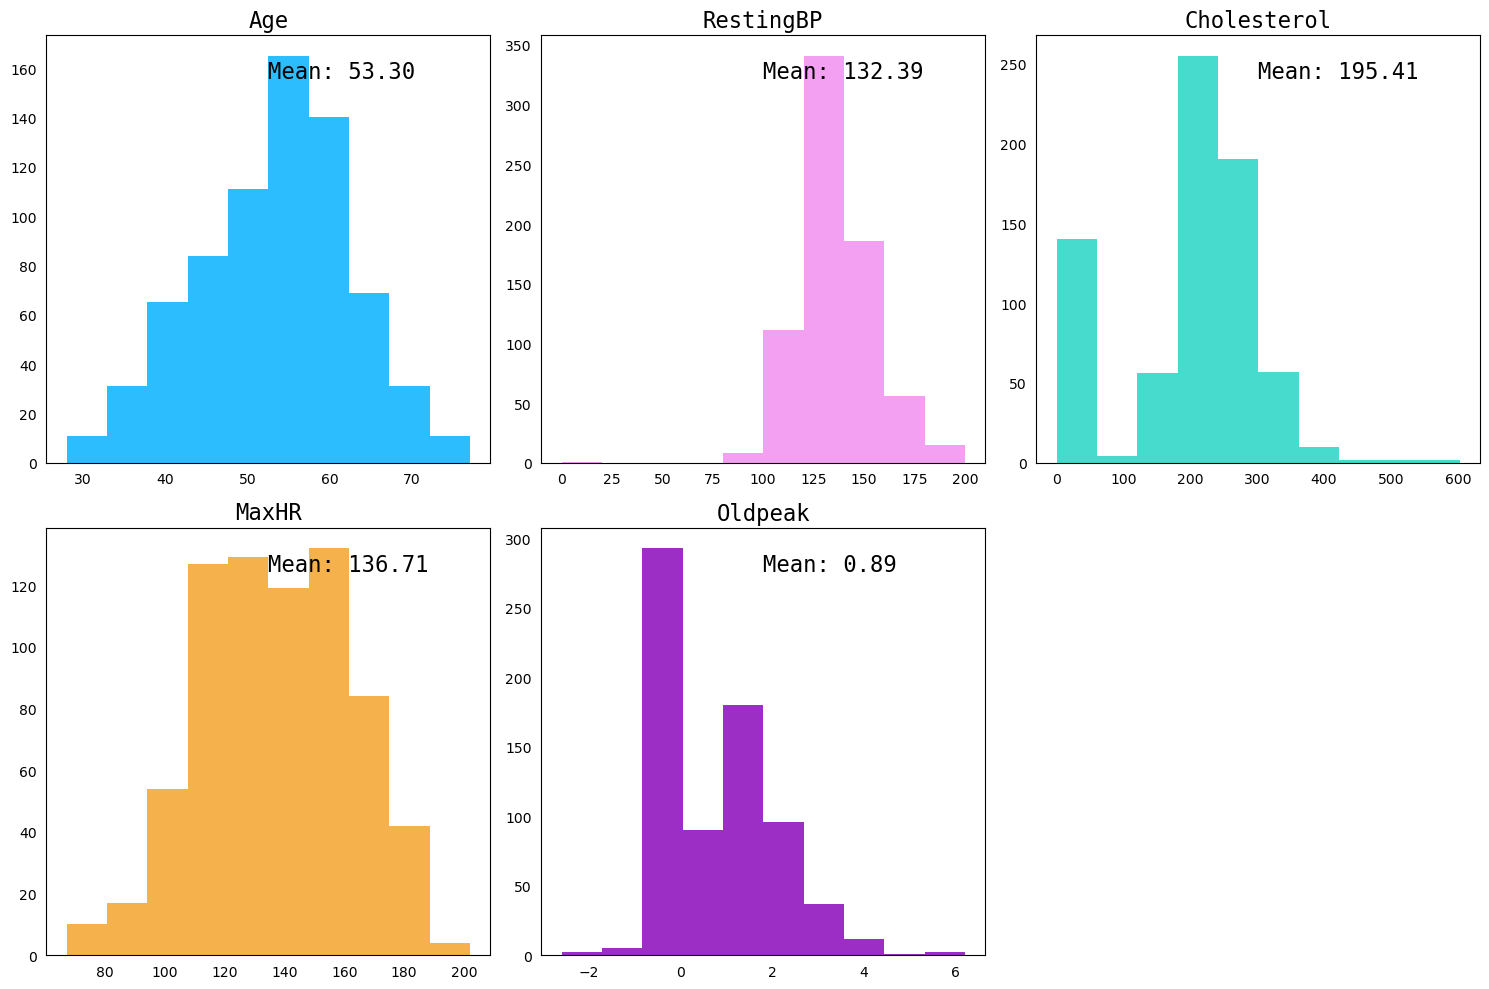

In [5]:
font_dict = {'family': 'monospace', 'color': 'black', 'size': 16}
# Plot histograms of numerical columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(NUMERICAL_COLS):
    ax = axes[i // 3, i % 3]
    ax.hist(train_data[col], color=color_list1[i])
    ax.set_title(col, fontdict=font_dict)
    ax.text(0.5, 0.9, f'Mean: {train_data[col].mean():.2f}', transform=ax.transAxes, fontdict=font_dict)
    ax.tick_params(left=False, bottom=False)
# Remove empty axes
fig.delaxes(axes[1][2])
plt.tight_layout()
plt.show()

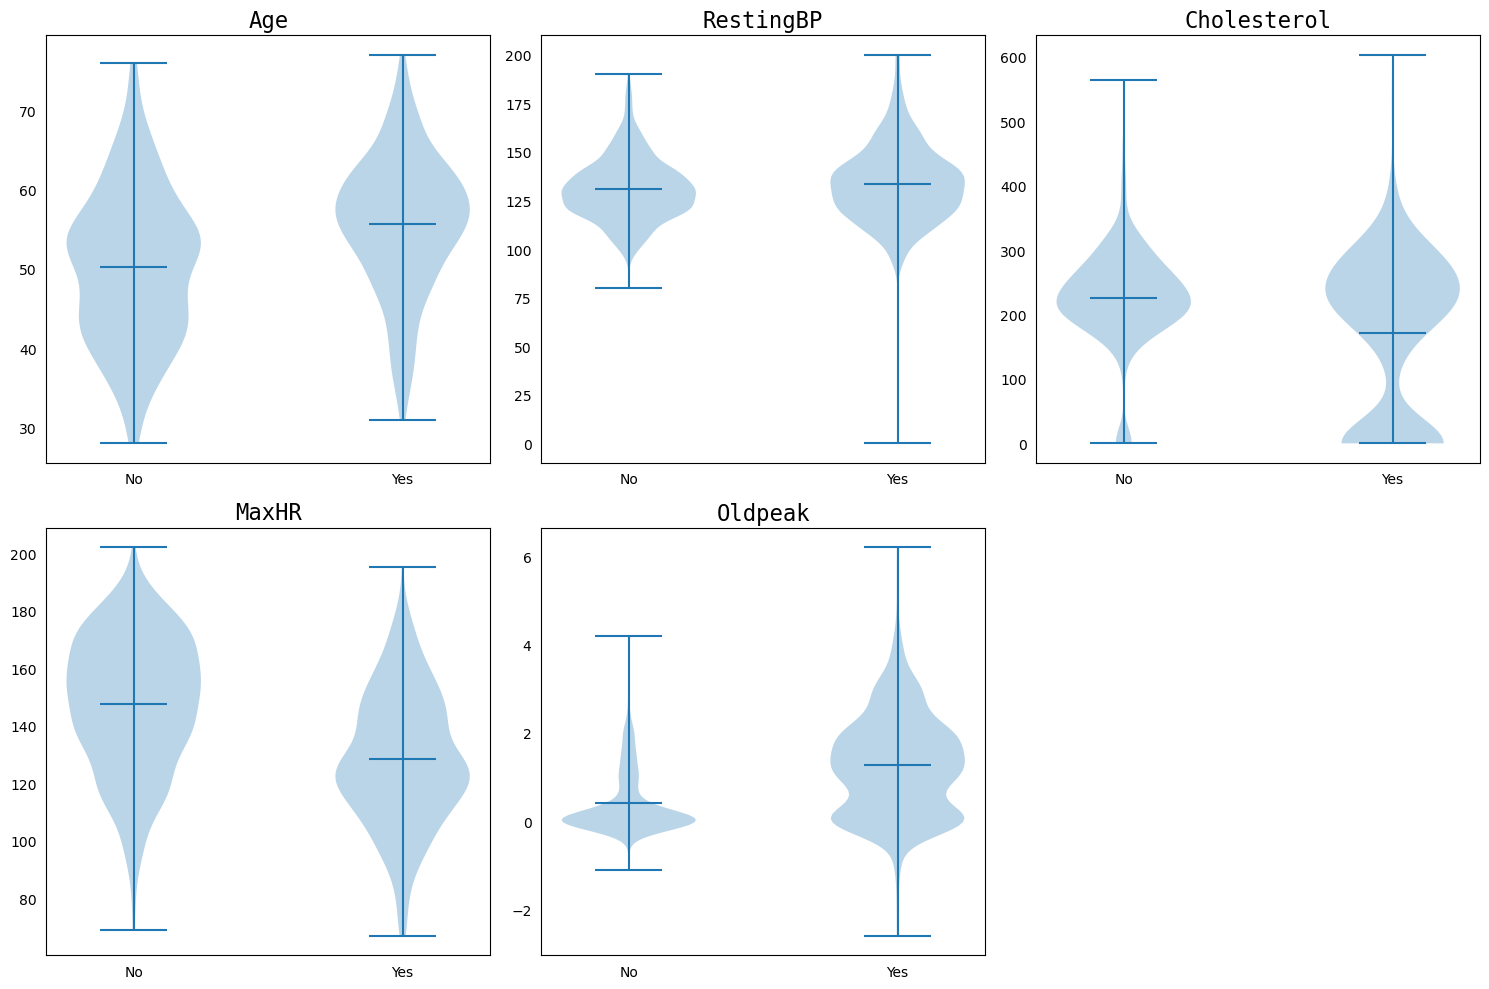

In [51]:
# Plot violin plots of numerical columns against HeartDisease
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(NUMERICAL_COLS):
    ax = axes[i // 3, i % 3]
    ax.violinplot([train_data[train_data['HeartDisease'] == 0][col], train_data[train_data['HeartDisease'] == 1][col]], showmeans=True)
    ax.set_title(col, fontdict=font_dict)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['No', 'Yes'])
    ax.tick_params(left=False, bottom=False)
# Remove empty axes
fig.delaxes(axes[1][2])
plt.tight_layout()


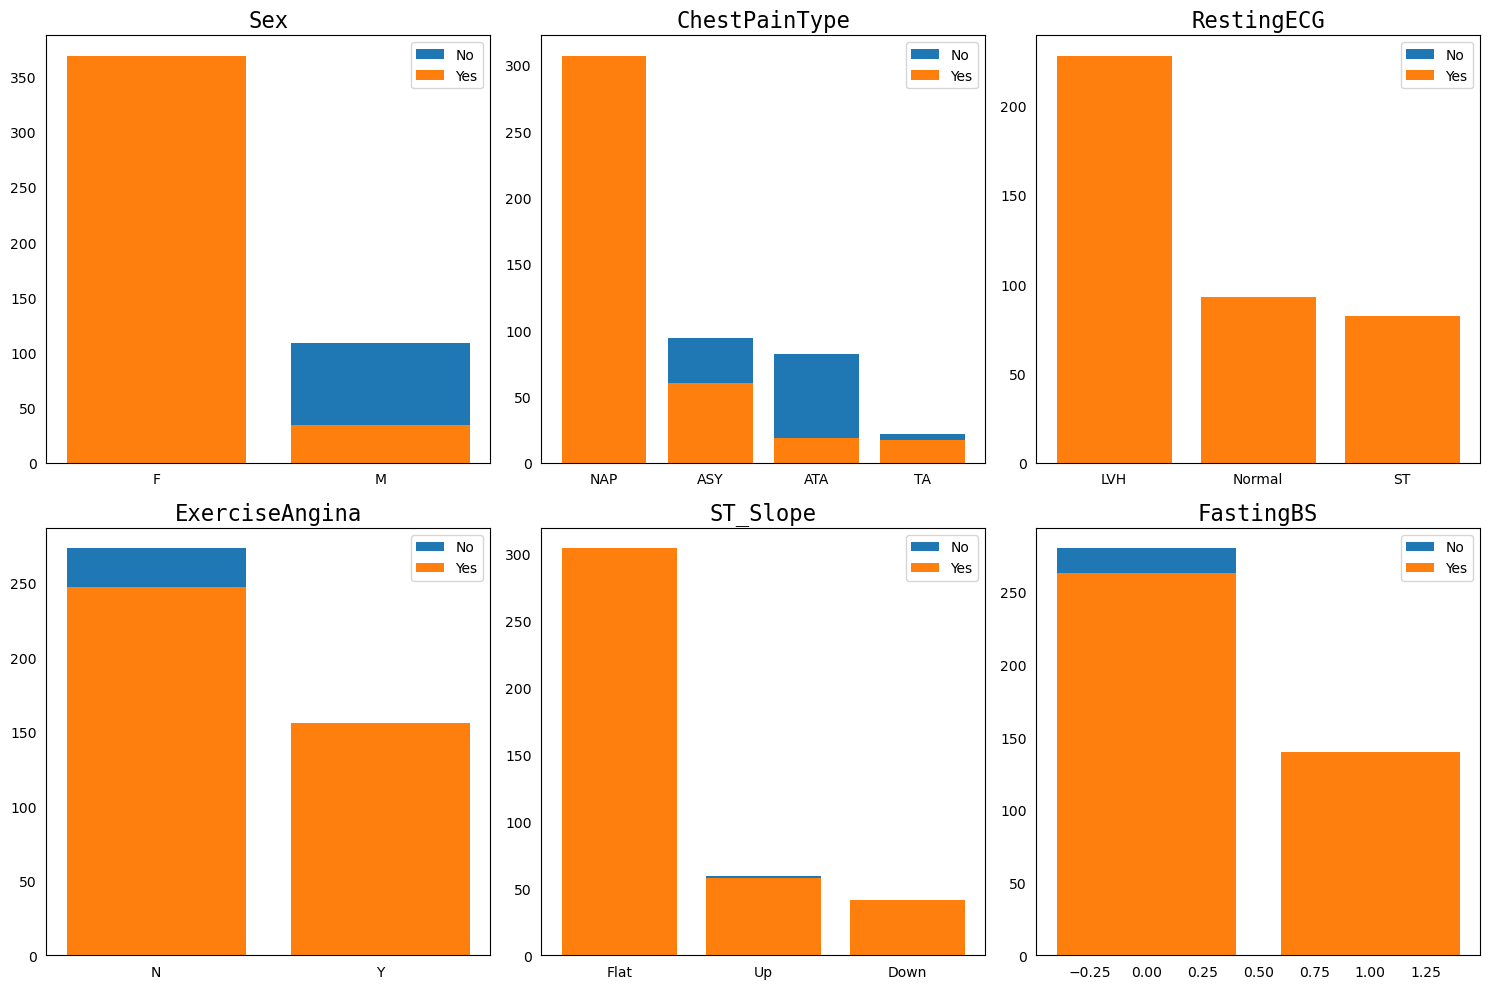

In [49]:
# Plot bar charts of categorical columns against target
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(CATEGORICAL_COLS):
    ax = axes[i // 3, i % 3]
    # Stacked bar chart
    ax.bar(train_data[col].unique(), train_data[train_data['HeartDisease']==0][col].value_counts(), label='No',)
    ax.bar(train_data[col].unique(), train_data[train_data['HeartDisease']==1][col].value_counts(), label='Yes',)
    ax.set_title(col, fontdict=font_dict)
    ax.tick_params(left=False, bottom=False)
    ax.legend()
plt.tight_layout()
plt.show()

## Classification

## Evaluation

## Iteration